In [22]:
import glob
import os
import warnings

import librosa
import librosa.display
import matplotlib.pylab as plt
import numpy as np

warnings.filterwarnings('ignore')

from utils import FMA_RAW, DATA_FOLDER, compute_mfcc, load_tracks

# Classes Distribution

In [23]:
tracks = load_tracks(DATA_FOLDER)

training = tracks['set', 'split'] == "training"
sm_tracks = tracks.loc[tracks['set', 'subset'] <= 'small']
md_tracks = tracks.loc[tracks['set', 'subset'] <= 'medium']

sm_values, sm_counts = np.unique(sm_tracks.loc[training]['track', 'genre_top'], return_counts=True)
md_values, md_counts = np.unique(md_tracks.loc[training]['track', 'genre_top'], return_counts=True)

sorted_idx = np.argsort(md_counts)

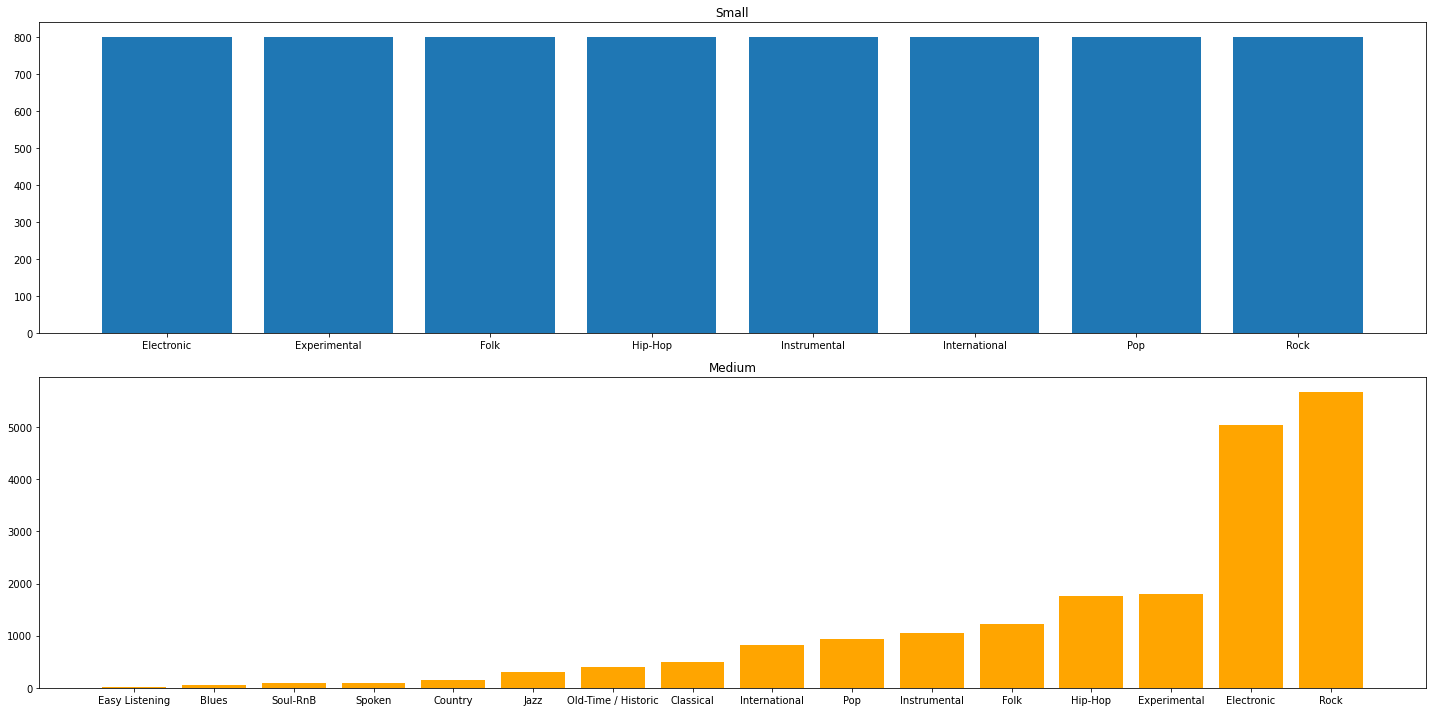

In [24]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 10))
ax1.bar(sm_values, sm_counts)
ax1.set_title("Small")
ax2.bar(md_values[sorted_idx], md_counts[sorted_idx], color='orange')
ax2.set_title("Medium")
fig.tight_layout()

In [25]:
# dataset split percentages
print("[Small]")
print(sm_tracks['set', 'split'].value_counts(normalize=True))

print("\n[Medium]")
print(md_tracks['set', 'split'].value_counts(normalize=True))

[Small]
training      0.8
validation    0.1
test          0.1
Name: (set, split), dtype: float64

[Medium]
training      0.79688
test          0.10292
validation    0.10020
Name: (set, split), dtype: float64


# RAW audio analysis

In [26]:
files = glob.glob(os.path.join(FMA_RAW, "**/*.mp3"), recursive=True)

In [43]:
examples = [
    {"filename": files[0], "genre": "Rock"},
    {"filename": files[25], "genre": "Rock"},
    {"filename": files[1], "genre": "Electronic"},
    {"filename": files[23], "genre": "Instrumental"},
    {"filename": files[99], "genre": "Pop"}
]

In [28]:
def plot_signal(filepath, seconds=10, title=None):
    y, sr = librosa.load(filepath, sr=None, mono=True)

    y = y[:sr * seconds]

    fft = np.abs(np.fft.fft(y))
    stft = librosa.stft(y, hop_length=512)
    mel = librosa.feature.melspectrogram(sr=sr, S=np.abs(stft) ** 2)
    stft_log = librosa.amplitude_to_db(np.abs(stft))
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=13)

    fig, axes = plt.subplots(5, 1, figsize=(10, 8))

    librosa.display.waveshow(y, sr=sr, ax=axes[0], x_axis="time")
    axes[1].plot(np.linspace(0, sr, len(fft))[:int(len(fft) / 2)], fft[:int(len(fft) / 2)])
    librosa.display.specshow(stft_log, sr=sr, ax=axes[2], x_axis="time", y_axis="log")
    librosa.display.specshow(mel, sr=sr, ax=axes[3], x_axis="time", y_axis="mel")
    librosa.display.specshow(mfcc, sr=sr, ax=axes[4], x_axis="time")

    axes[0].set_ylabel("Amplitude")
    axes[1].set_ylabel("Magnitude")
    axes[1].set_xlabel("Hz")
    axes[4].set_ylabel("MFCC")

    fig.suptitle(title)
    fig.tight_layout()
    fig.show()

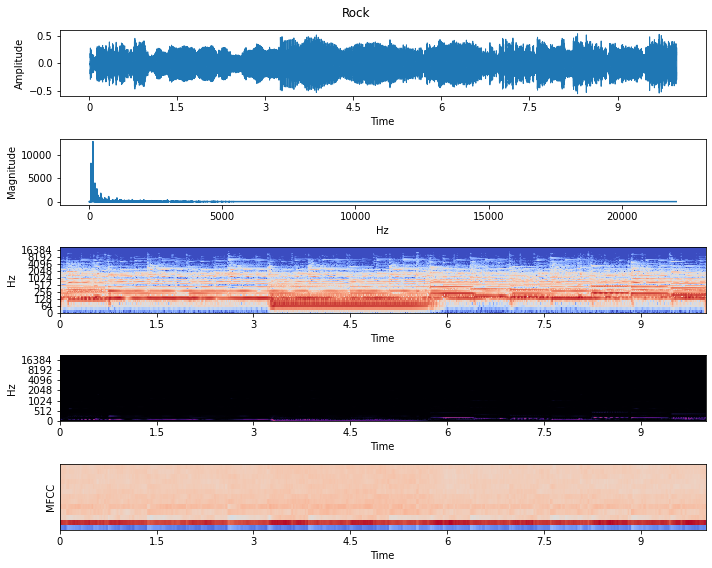

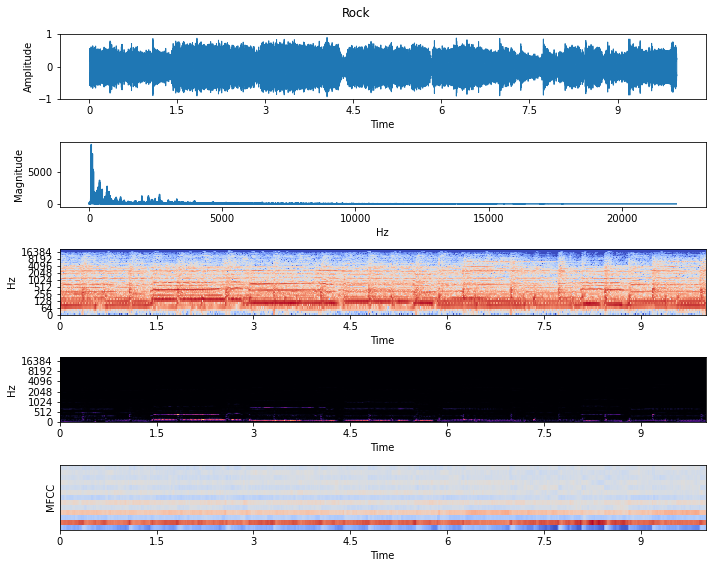

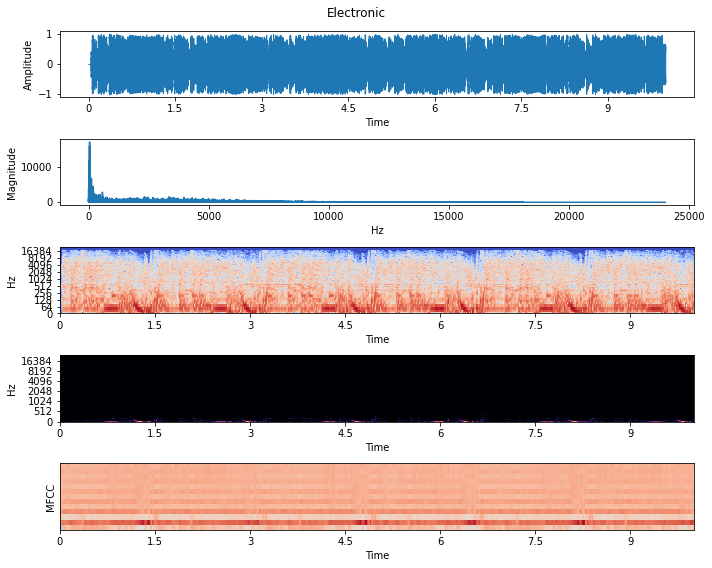

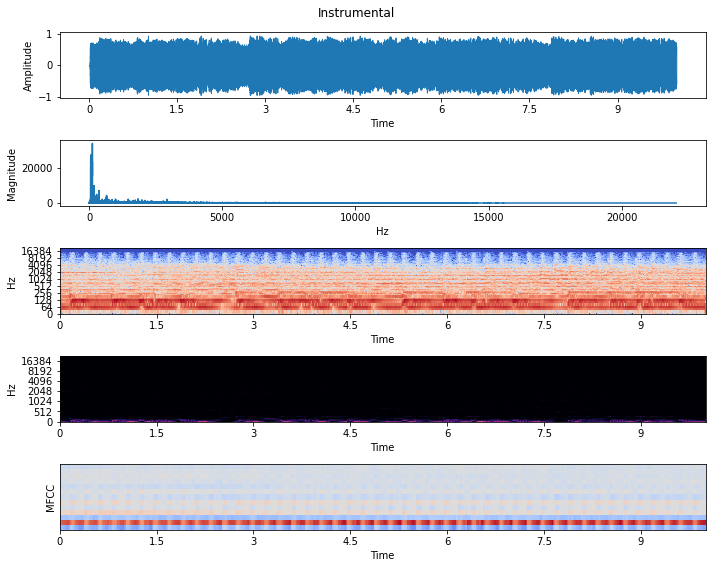

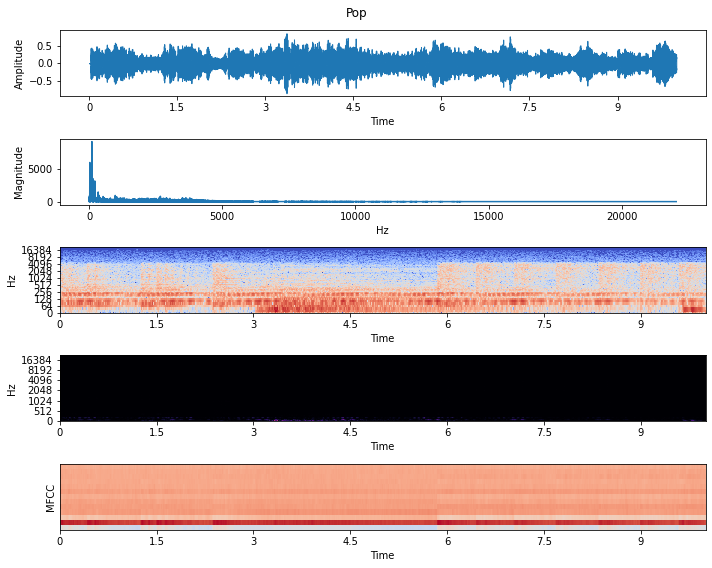

In [46]:
for e in examples:
    plot_signal(e["filename"], title=e["genre"])

In [30]:
def plot_mfcc(filepath, sr=44100, seconds=10, title=None):
    mfcc_delta = compute_mfcc(filepath, duration=seconds)

    fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex='all', sharey='all')

    librosa.display.specshow(mfcc_delta[0:13, :], sr=sr, ax=axes[0], x_axis="time")
    librosa.display.specshow(mfcc_delta[13:26, :], sr=sr, ax=axes[1], x_axis="time")
    librosa.display.specshow(mfcc_delta[26:, :], sr=sr, ax=axes[2], x_axis="time")

    axes[0].set_xlabel("")
    axes[1].set_xlabel("")
    axes[0].set_ylabel("MFCC")
    axes[1].set_ylabel(r"$\Delta$MFCC")
    axes[2].set_ylabel(r"$\Delta\Delta$MFCC")

    fig.suptitle(title)
    fig.tight_layout()
    fig.show()

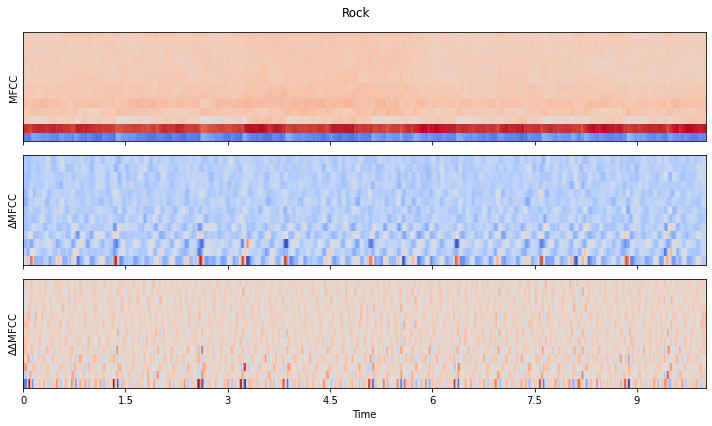

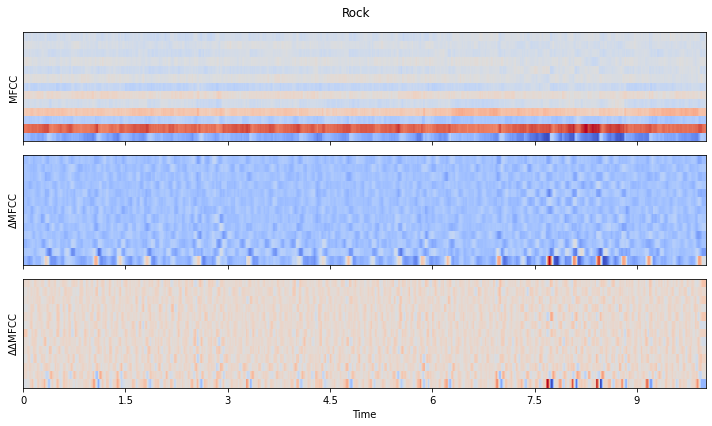

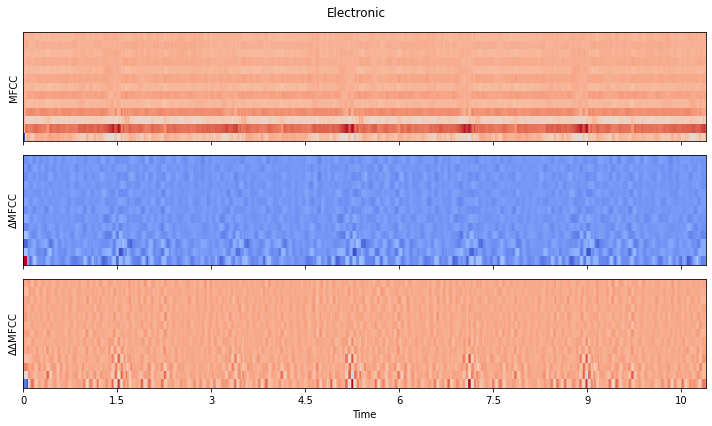

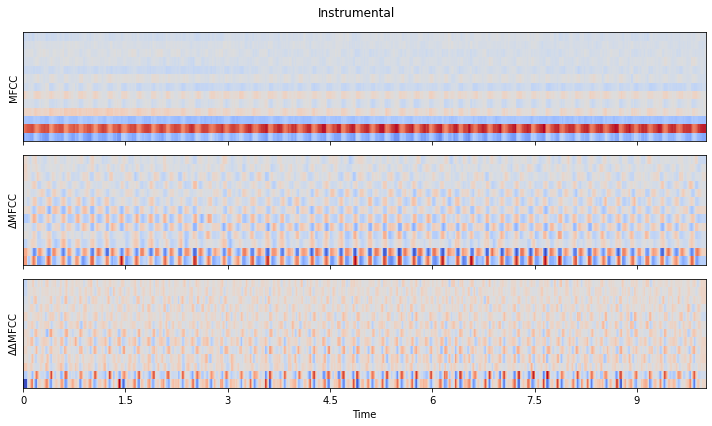

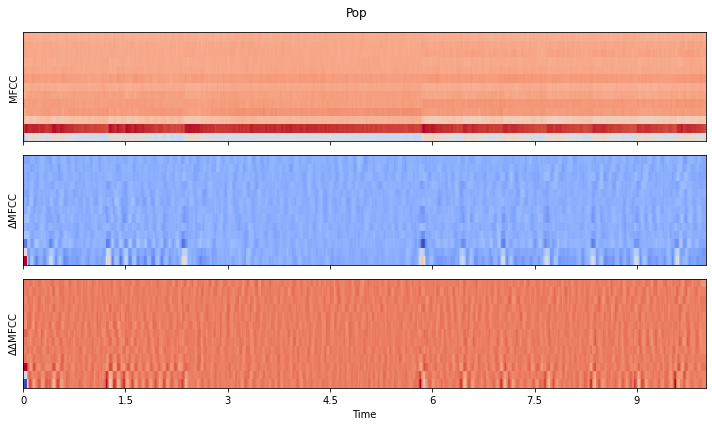

In [47]:
for e in examples:
    plot_mfcc(e["filename"], title=e["genre"])

# Check for Bad Samples

In [ ]:
import pandas as pd
from multiprocessing import Pool

from bad_samples import get_ignore_list
from utils import OUTPUT_FOLDER

for f in get_ignore_list("medium"):
    f = os.path.join(FMA_RAW, f)
    if f in files:
        files.remove(f)


def get_infos(filepath):
    y, sr = librosa.load(filepath, sr=None, mono=True)
    return sr, librosa.get_duration(y, sr=sr)


# get durations and sample rates

durations = []
sample_rates = []
with Pool(processes=6) as pool:
    for i, (sr, d) in enumerate(pool.imap(get_infos, files, chunksize=500)):
        durations.append(d)
        sample_rates.append(sr)

        try:
            if i % 500 == 0:
                print(i, (sr, d))
        except Exception:
            pass

                  0
count  24979.000000
mean   44228.403859
std     1219.252675
min    22050.000000
25%    44100.000000
50%    44100.000000
75%    44100.000000
max    48000.000000


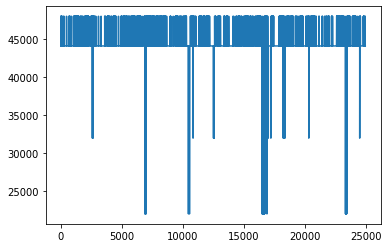

In [55]:
plt.plot(sample_rates)

sample_rates = np.array(sample_rates)
sample_rates = pd.DataFrame(sample_rates)
indexes = sample_rates.loc[sample_rates[0] != 44100].index

bad_files = list(np.array(files)[indexes])
np.save(os.path.join(OUTPUT_FOLDER, "bad_samples_files"), bad_files)
print(sample_rates.describe())

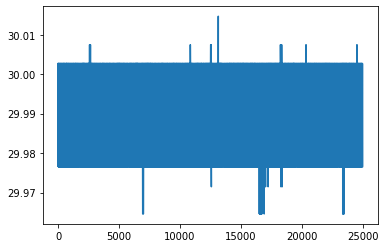

                  0
count  24979.000000
mean      29.988065
std        0.012691
min       29.964580
25%       29.976576
50%       29.976576
75%       30.002698
max       30.014694


In [56]:
plt.plot(durations)
plt.show()

durations = np.array(durations)
durations = pd.DataFrame(durations)

print(durations.describe())

In [57]:
print(sum(durations[0] <= 30))
print(sum(durations[0] >  30))
print(sum(durations[0] <= 29.95))

14513
10466
0
